In [1]:
import os

import numpy as np
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
from voxelwise_tutorials.utils import generate_leave_one_run_out

from compare_variance_residual.fmri.features import load_feature, load_brain_data

In [2]:
data_dir = "../../data"
backend = set_backend("torch_cuda")

In [16]:
subject = 5
modality = 'listening'
low_level_feature = "powspec"

In [4]:
alphas = np.logspace(-5, 15, 21)
number_of_delays = 4
n_targets_batch = 100
n_alphas_batch = 3
n_targets_batch_refit = 50

# Load data

In [5]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
Y, n_samples_train, ev = load_brain_data(data_dir, subject, modality)
print(Y.shape)
print(n_samples_train)
print(Y.shape[0] - n_samples_train)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/featu

(4028, 92970)
3737
291


In [17]:
X_low, n_samples_train = load_feature(data_dir, low_level_feature)
print(X_low.shape)
print(n_samples_train)
print(X_low.shape[0] - n_samples_train)

(4028, 448)
3737
291


In [18]:
X_high, n_samples_train = load_feature(data_dir, 'english1000')
print(X_high.shape)
print(n_samples_train)
print(X_high.shape[0] - n_samples_train)

(4028, 985)
3737
291


# Run cross-feature model

In [19]:
from himalaya.ridge import RidgeCV

# powspec 6 best

# moten
# 5 np.float32(0.0054762564)
# 6 np.float32(0.0055091255)
cross_model = RidgeCV(cv=5, alphas=alphas,
                      solver_params=dict(n_targets_batch=n_targets_batch, n_alphas_batch=n_alphas_batch,
                                         n_targets_batch_refit=n_targets_batch_refit))
cross_model.fit(X_low[:n_samples_train], X_high[:n_samples_train])
cross_model

RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10,
       1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15]),
        solver_params={'n_alphas_batch': 3, 'n_targets_batch': 100,
                       'n_targets_batch_refit': 50})

tensor(1.0000e+11, device='cuda:0') tensor(100., device='cuda:0')


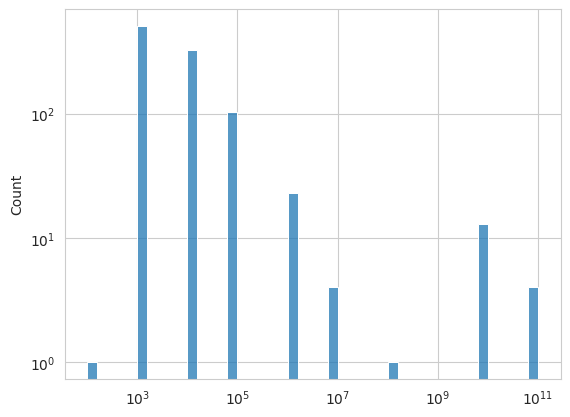

In [20]:
import seaborn as sns

sns.histplot(backend.to_numpy(cross_model.best_alphas_), log_scale=(True))
plt.yscale("log")
print(cross_model.best_alphas_.max(), cross_model.best_alphas_.min())

In [21]:
score = cross_model.score(X_low[n_samples_train:], X_high[n_samples_train:])
score = backend.to_numpy(score)
score.mean()

np.float32(0.08002354)

<Axes: ylabel='Count'>

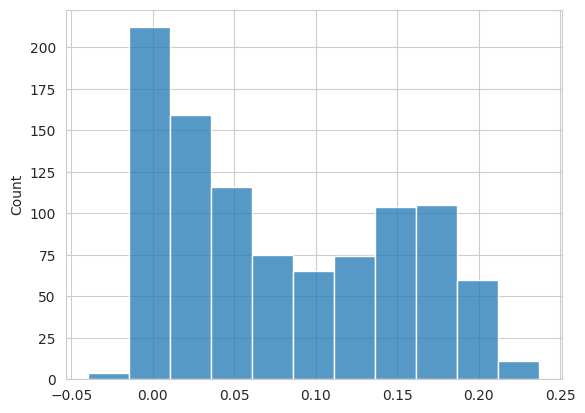

In [22]:
sns.histplot(score)